## Introduction
## Image Denoising  using Convolution Autoencoders



In many real-world applications, images are affected by noise introduced during acquisition, compression, or transmission. This noise degrades image quality and can significantly reduce the performance of downstream Machine Learning algorithms such as image classification, detection, or segmentation. Therefore, image denoising is an important pre-processing step to make images more amenable to Machine Learning models.

In this notebook, we explore image denoising using convolutional autoencoders applied to RGB photographs. A convolutional autoencoder is a neural network architecture composed of two main parts:

Encoder: compresses the input image into a lower-dimensional latent representation by learning meaningful visual features.

Decoder: reconstructs the original image from this latent representation, ideally removing noise while preserving important structures.

The objective of the autoencoder is not to classify images, but to reconstruct a clean version of an image from a noisy input. This makes autoencoders particularly well-suited for image denoising tasks.



In [1]:
import sys
print(sys.executable)


c:\dev\photonon\cnn_pytorch_env\Scripts\python.exe


In [2]:
# Core libraries
import os
import random
import numpy as np

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import make_grid

# Image handling
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [3]:
# Device configuration (CPU / GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 5
NOISE_STD = 0.2


In [5]:
# Image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])


In [6]:
class CleanImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [8]:
CLEAN_DIR = r"C:\dev\photonon\data_binary\Photo"

clean_dataset = CleanImageDataset(
    image_dir=CLEAN_DIR,
    transform=transform
)

clean_loader = DataLoader(
    clean_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


In [9]:
def add_synthetic_noise(images, noise_std=NOISE_STD):
    """
    Add Gaussian noise to a batch of images.
    images: Tensor of shape (B, 3, H, W) with values in [0,1]
    noise_std: controls the noise strength
    """
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)  # keep valid pixel range
    return noisy_images


In [10]:
clean_batch = next(iter(clean_loader))          # (B, 3, H, W)
noisy_batch = add_synthetic_noise(clean_batch)  # same shape
print("Clean batch shape:", clean_batch.shape)
print("Noisy batch shape:", noisy_batch.shape)


Clean batch shape: torch.Size([16, 3, 128, 128])
Noisy batch shape: torch.Size([16, 3, 128, 128])


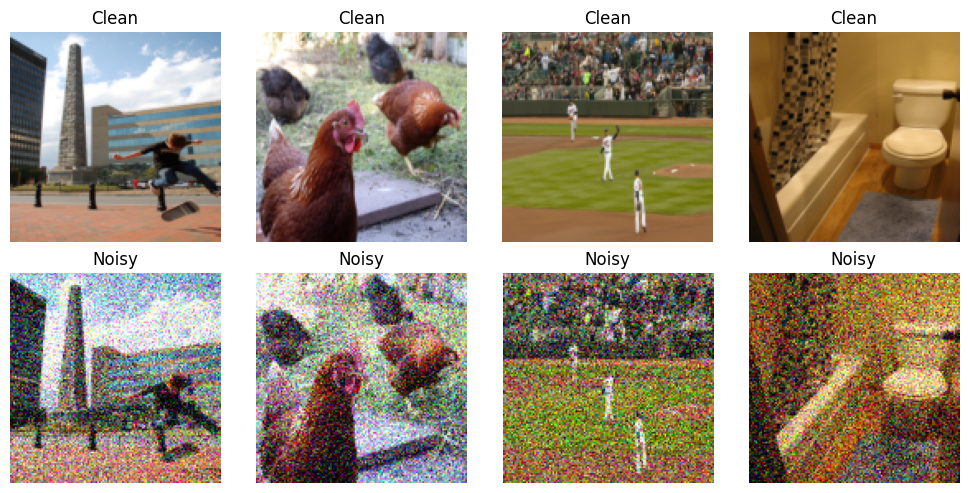

In [11]:
n_show = 4
plt.figure(figsize=(10, 5))

for i in range(n_show):
    # Clean
    plt.subplot(2, n_show, i + 1)
    plt.imshow(clean_batch[i].permute(1, 2, 0))
    plt.title("Clean")
    plt.axis("off")

    # Noisy
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(noisy_batch[i].permute(1, 2, 0))
    plt.title("Noisy")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: (3, 128, 128) -> (128, 16, 16)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),                               # (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                               # (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2)                                # (128, 16, 16)
        )

        # Decoder: (128, 16, 16) -> (3, 128, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # (64, 32, 32)
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # (32, 64, 64)
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),    # (3, 128, 128)
            nn.Sigmoid()  # keep outputs in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
model = DenoisingAutoencoder().to(device)
print(model)

# quick shape check using a dummy batch
dummy = torch.randn(2, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
out = model(dummy)
print("Input shape :", dummy.shape)
print("Output shape:", out.shape)


DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)
Input shape : torch.Size([2, 3, 128, 128])
Output shape: torch.Size([2, 3, 128, 128])


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [15]:
def train_autoencoder(model, dataloader, epochs):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0

        for clean_images in dataloader:
            clean_images = clean_images.to(device)

            # Create noisy inputs
            noisy_images = add_synthetic_noise(clean_images)

            # Forward pass
            outputs = model(noisy_images)

            # Compute reconstruction loss
            loss = criterion(outputs, clean_images)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")

    return loss_history


In [16]:
loss_history = train_autoencoder(
    model=model,
    dataloader=clean_loader,
    epochs=3
)


Epoch [1/3] - Loss: 0.0163
Epoch [2/3] - Loss: 0.0078
Epoch [3/3] - Loss: 0.0066
